**Input Features:**
- Years of Experience: The number of years of experience required for the job, which has been processed to be a numeric value.
- Role: The job role (e.g., Developer, Senior, Manager). This is one-hot encoded into multiple binary columns, one for each role type.
- Additional features (optional): Other features in your dataset can be included, such as the company, job title, etc. But in your current example, only Years of Experience and Role are used for training the model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [ ]:
# Parsing functions
def parse_experience(x):
    x = str(x)
    if '-' in x:
        low, high = x.split('-')
        return (float(low) + float(high)) / 2
    return float(x)

def parse_salary_range(s):
    s = str(s).lower().replace('$', '').strip()
    if '-' in s:
        low, high = s.split('-')
        return (float(low) + float(high)) / 2
    elif s.isdigit():
        return float(s)
    else:
        return np.nan

1. Load and Combine Data
Read CSV Files:
df is loaded from merged_data.csv.
new_data is loaded from merged_data2.csv.
Combine Data:
The datasets are concatenated using pd.concat().
Invalid rows (where Required Skills is NaN or empty) are removed using combined_data[~combined_data['Required Skills'].isna() & (combined_data['Required Skills'] != '')].
2. Data Parsing
Parsing Experience: The parse_experience function is applied to extract "Years of Experience" from text.
Parsing Salary: The parse_salary_range function is applied to compute a numerical salary value from a "Salary Range" column.
3. Outlier Removal
[Q1−1.5×IQR,Q3+1.5×IQR] are considered outliers and removed.
4. Handle Missing Values
Rows with missing values in Years of Experience or Salary are dropped using dropna().
5. Feature Transformation
Numeric Features:

- Years of Experience undergoes preprocessing:
Missing values are filled with the mean (SimpleImputer).
Polynomial features are generated with degree 2, creating interaction terms (PolynomialFeatures).
Categorical Features:

- Role, Level, and Location are preprocessed:
Missing values are replaced with the string 'missing'.
One-hot encoding is applied to convert categorical variables into binary columns.
Preprocessor: A ColumnTransformer is used to apply numeric and categorical transformations.

6. Model Pipeline
A pipeline is created to:
Apply preprocessing (preprocessor).
Train a linear regression model (LinearRegression).
7. Train-Test Split
The combined dataset is split into training (80%) and testing (20%) sets using train_test_split().
8. Train and Predict
Model Training: The pipeline is fitted on X_train (features) and y_train (target salary).
Prediction: Predictions are generated for the test set (X_test).
9. Model Evaluation
R² Score: The coefficient of determination (
𝑅
2
R
2
 ) is computed to measure model performance, indicating how well the regression predictions fit the data. A higher score implies better performance.
Output
The updated model's
𝑅
2
R
2
  score is printed to show the evaluation result of the trained model on the test data.

In [ ]:
# Load original and new data
df = pd.read_csv('/content/merged_data.csv')
new_data = pd.read_csv('/content/merged_data2.csv')

combined_data = pd.concat([df, new_data], ignore_index=True)
combined_data = combined_data[~combined_data['Required Skills'].isna() & (combined_data['Required Skills'] != '')]

# Apply the parsing functions
combined_data['Years of Experience'] = combined_data['Years of Experience'].apply(parse_experience)
combined_data['Salary'] = combined_data['Salary Range'].apply(parse_salary_range)

# Remove potential outliers
Q1 = combined_data['Salary'].quantile(0.25)
Q3 = combined_data['Salary'].quantile(0.75)
IQR = Q3 - Q1
combined_data = combined_data[
    (combined_data['Salary'] >= Q1 - 1.5 * IQR) &
    (combined_data['Salary'] <= Q3 + 1.5 * IQR)
]

# Drop missing values
combined_data = combined_data.dropna(subset=['Years of Experience', 'Salary'])

# Define numeric and categorical features
numeric_features = ['Years of Experience']
categorical_features = ['Role', 'Level', 'Location']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Features and target variable
X_combined = combined_data[['Years of Experience', 'Role', 'Level', 'Location']]
y_combined = combined_data['Salary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
# Train the model on combined data
pipeline.fit(X_train, y_train)

prediction = pipeline.predict(X_test)

# Evaluate the new model
new_score = pipeline.score(X_test, y_test)
print(f'Updated Model R^2 Score: {new_score}')

Updated Model R^2 Score: 0.23443736592582898
Mean Squared Error: 219760.1407563052


# Save model to file

In [ ]:
# Save the LinearRegression model
joblib.dump(pipeline, 'linear_model.pkl')

['linear_model.pkl']

# Calculate Metrics

- Error Metrics:
  + MSE: Average squared prediction error
  + MAE: Average absolute prediction error
  + RMSE: Square root of MSE, gives error in same units as target variable

- Variance Metrics:
  + Explained variance: Proportion of variance captured (0-1)
  + R²: Proportion of variance explained (-∞ to 1)
  + Adjusted R²: R² adjusted for number of predictors

In [ ]:
# Calculate metrics

# Measures the average squared difference between the predicted values and the actual values.
# A lower MSE indicates a better fit of the model to the data.
mse = mean_squared_error(y_test, prediction)

# Measures the average absolute difference between the predicted and actual values.
mae = mean_absolute_error(y_test, prediction)

# Square root of the average squared differences between predictions and actual values.
rmse = np.sqrt(mse)

# Measures the proportion of the variance in the target variable that is captured by the model.
# Values range from 0 to 1 (higher is better).
explained_variance = explained_variance_score(y_test, prediction)

# Measures the proportion of variance in the dependent variable explained by the independent variables.
# Ranges from -inf to 1. (1 is perfect)
r2 = r2_score(y_test, prediction)

# Calculate Adjusted R² to account for the number of predictors in the model.
n = X_test.shape[0]  # Number of samples
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Residuals represent the difference between actual and predicted values for each observation.
# Helps identify patterns, heteroscedasticity (variance inconsistency), or outliers in the model.
residuals = y_test - prediction

# Create a dictionary with the evaluation metrics
metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)',
               'Explained Variance Score', 'R² Score', 'Adjusted R² Score'],
    'Value': [mse, mae, rmse, explained_variance, r2, adjusted_r2]
}

# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Value
0,Mean Squared Error (MSE),219760.140756
1,Mean Absolute Error (MAE),383.318016
2,Root Mean Squared Error (RMSE),468.785815
3,Explained Variance Score,0.234583
4,R² Score,0.234437
5,Adjusted R² Score,0.213172


# Visualize them

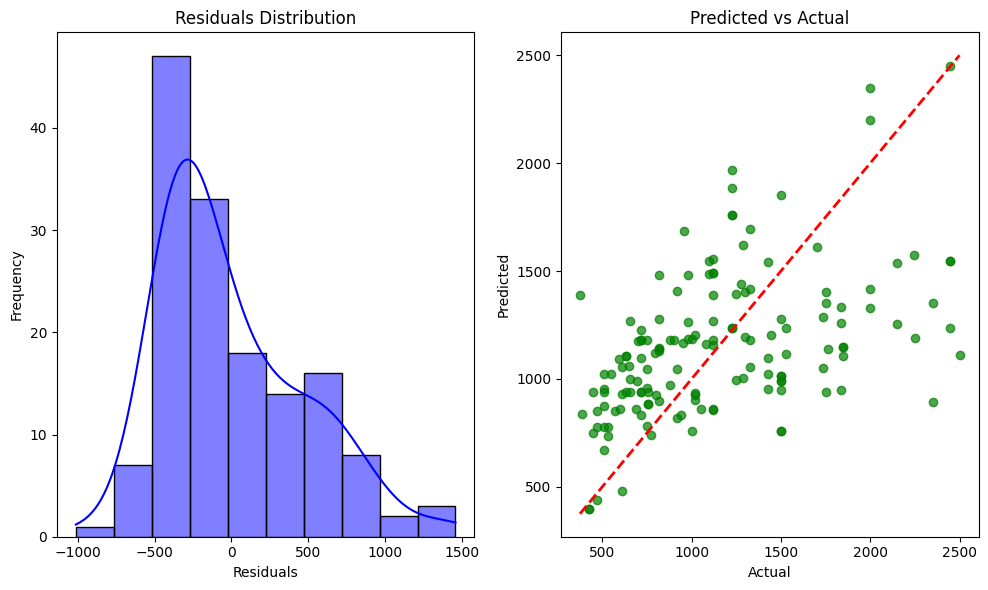

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the residuals
plt.figure(figsize=(10, 6))

# Residuals plot
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='blue', bins=10)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Scatter plot for predicted vs actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, prediction, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Show plots
plt.tight_layout()
plt.show()

# Generate data

- Data Structure:
  + Creates 150 total records (50 each for Junior/Intermediate/Senior)
  + Fields: Years of Experience, Role, Level, Required Skills, Location

- Key Components:
  + Experience ranges: Junior (1-2 years), Intermediate (3-5), Senior (5-15)
  + Roles: Data Engineer and Software Engineer
  + Predefined skill sets for each role/level combination
  + Locations: 5 major Vietnamese cities

- Data Generation Process:
  + Creates separate DataFrames for each level
  + Assigns random skills based on role/level
  + Randomly assigns Vietnamese cities
  + Combines all data into final_data DataFrame

In [ ]:
import numpy as np

# Define the categories for 'Role' and 'Level'
levels = ['Junior', 'Intermediate', 'Senior']

# Generate random data
num_samples = 50  # Number of samples per level

# Create data for each level
junior_data = {
    'Years of Experience': np.random.randint(1, 2, num_samples),
    'Role': 'data engineer',
    'Level': 'Junior'
}

intermediate_data = {
    'Years of Experience': np.random.randint(3, 5, num_samples),
    'Role': 'software engineer',
    'Level': 'Intermediate'
}

senior_data = {
    'Years of Experience': np.random.randint(5, 15, num_samples),
    'Role': 'data engineer',
    'Level': 'Senior'
}

import random

# Define skills for each role and level
skills_dict = {
    'data engineer': {
        'Junior': ['SQL', 'Python', 'Data Wrangling', 'Basic ETL', 'Data Analysis'],
        'Intermediate': ['Apache Spark', 'AWS', 'Data Pipelines', 'ETL', 'Data Modeling'],
        'Senior': ['Big Data', 'Cloud Architecture', 'Advanced ETL', 'Data Warehousing', 'System Design']
    },
    'software engineer': {
        'Junior': ['JavaScript', 'HTML', 'CSS', 'Python', 'Basic Web Development'],
        'Intermediate': ['React', 'Node.js', 'Full-Stack Development', 'REST APIs', 'Database Management'],
        'Senior': ['Microservices', 'System Design', 'DevOps', 'Cloud Computing', 'Distributed Systems']
    }
}

# Function to generate random skills for each sample based on role and level
def generate_skills(row):
    role = row['Role']
    level = row['Level']
    skills = skills_dict.get(role, {}).get(level, [])
    # Randomly select a subset of skills (up to 5 skills)
    return ', '.join(random.sample(skills, k=min(5, len(skills))))

# Define Vietnamese cities
vietnamese_cities = [
    'Hà Nội', 'Hồ Chí Minh', 'Đà Nẵng', 'Hải Phòng', 'Cần Thơ'
]

# Function to assign a random Vietnamese city
def assign_city():
    return random.choice(vietnamese_cities)

# Create DataFrames for each level
junior_df = pd.DataFrame(junior_data)
intermediate_df = pd.DataFrame(intermediate_data)
senior_df = pd.DataFrame(senior_data)

# Concatenate DataFrames
final_data = pd.concat([junior_df, intermediate_df, senior_df], ignore_index=True)

# Apply the function to generate required skills
final_data['Required Skills'] = final_data.apply(generate_skills, axis=1)

# Assign random Vietnamese cities to the 'Location' column
final_data['Location'] = final_data.apply(lambda _: assign_city(), axis=1)

# Display first few rows
print(final_data.head())

   Years of Experience           Role   Level  \
0                    1  data engineer  Junior   
1                    1  data engineer  Junior   
2                    1  data engineer  Junior   
3                    1  data engineer  Junior   
4                    1  data engineer  Junior   

                                     Required Skills   Location  
0  Basic ETL, Python, Data Wrangling, Data Analys...  Hải Phòng  
1  Data Analysis, Basic ETL, SQL, Python, Data Wr...    Đà Nẵng  
2  SQL, Data Analysis, Python, Data Wrangling, Ba...  Hải Phòng  
3  SQL, Data Analysis, Data Wrangling, Basic ETL,...    Cần Thơ  
4  Data Analysis, Basic ETL, Data Wrangling, SQL,...     Hà Nội  


# Test on data

In [ ]:
# Predict salaries using the trained model
predictions = pipeline.predict(final_data)

# Add the predicted salaries to the new data
final_data['Predicted Salary'] = predictions
final_data.to_csv("predicted.csv")

# Use Model

## Load model REMEMBER TO CHANGE PATH

In [ ]:
import joblib

# Load the trained RandomForestRegressor model
model = joblib.load('/content/linear_model.pkl') #

## Predict

In [ ]:
predictions = model.predict(final_data)
# Show the predictions
print("Predictions for new data:", predictions)

Predictions for new data: [1055.72995497 1052.11384061 1055.72995497 1055.72995497 1079.29349887
 1055.72995497 1052.11384061 1052.11384061 1055.72995497 1060.41092142
 1052.11384061 1052.11384061 1060.41092142 1060.41092142 1055.72995497
 1079.29349887 1052.11384061 1060.41092142 1052.11384061 1055.72995497
 1079.29349887 1052.11384061 1079.29349887 1052.11384061 1052.11384061
 1055.72995497 1055.72995497 1079.29349887 1055.72995497 1079.29349887
 1055.72995497 1079.29349887 1055.72995497 1060.41092142 1060.41092142
 1052.11384061 1055.72995497 1079.29349887 1060.41092142 1055.72995497
 1052.11384061 1055.72995497 1052.11384061 1060.41092142 1055.72995497
 1079.29349887 1060.41092142 1079.29349887 1055.72995497 1079.29349887
 1175.28703035 1115.08722593 1096.20464848 1115.08722593 1175.28703035
 1175.28703035 1096.20464848 1175.28703035 1175.28703035 1087.90756767
 1171.670916   1179.96799681 1175.28703035 1115.08722593 1091.52368203
 1171.670916   1087.90756767 1115.08722593 1175.287